In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, datasets, models

In [3]:
import pathlib

# load in dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [4]:
# count how many images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


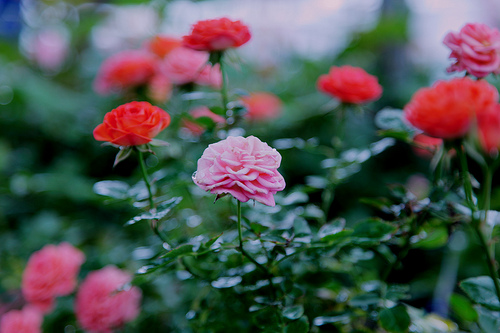

In [5]:
# display one class
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [6]:
# define parameters for loader
batch_size = 32
img_height = 180
img_width = 180

# 80% images for training, 20% for validation
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
print('abc', train_ds)
true_label = np.concatenate([y for x, y in train_ds], axis=0)
print(true_label)
img = np.concatenate([x for x, y in train_ds], axis=0)
print(img)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
abc <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


2024-08-08 18:12:37.682880: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[2 1 4 ... 2 0 4]


2024-08-08 18:12:38.387222: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[[[[8.83888855e+01 1.24388885e+02 2.00388885e+02]
   [8.89277802e+01 1.24927780e+02 2.00927780e+02]
   [8.88342590e+01 1.25369446e+02 1.99212967e+02]
   ...
   [2.14580002e+02 8.65392227e+01 2.93608099e-01]
   [2.33405533e+02 1.02674973e+02 5.17222071e+00]
   [2.28703690e+02 9.76851730e+01 2.50831127e+00]]

  [[9.02777786e+01 1.26277779e+02 2.02277786e+02]
   [9.08666611e+01 1.27150002e+02 2.03008331e+02]
   [9.50527802e+01 1.33036102e+02 2.06155548e+02]
   ...
   [1.61444656e+02 6.94110336e+01 9.16383362e+00]
   [1.72708313e+02 6.47249908e+01 1.37494314e+00]
   [1.53869415e+02 6.37055588e+01 4.15557909e+00]]

  [[9.30277786e+01 1.31027786e+02 2.06027786e+02]
   [9.27500000e+01 1.30819443e+02 2.05819443e+02]
   [9.83518524e+01 1.37162033e+02 2.09879623e+02]
   ...
   [1.18514069e+02 5.96759567e+01 8.26373959e+00]
   [1.67694931e+02 1.02569954e+02 4.29171982e+01]
   [2.26222305e+02 1.90916809e+02 1.68245590e+02]]

  ...

  [[8.00000458e+01 1.02430565e+02 3.50880051e+01]
   [8.55555191e+

(32, 180, 180, 3)
(32,)


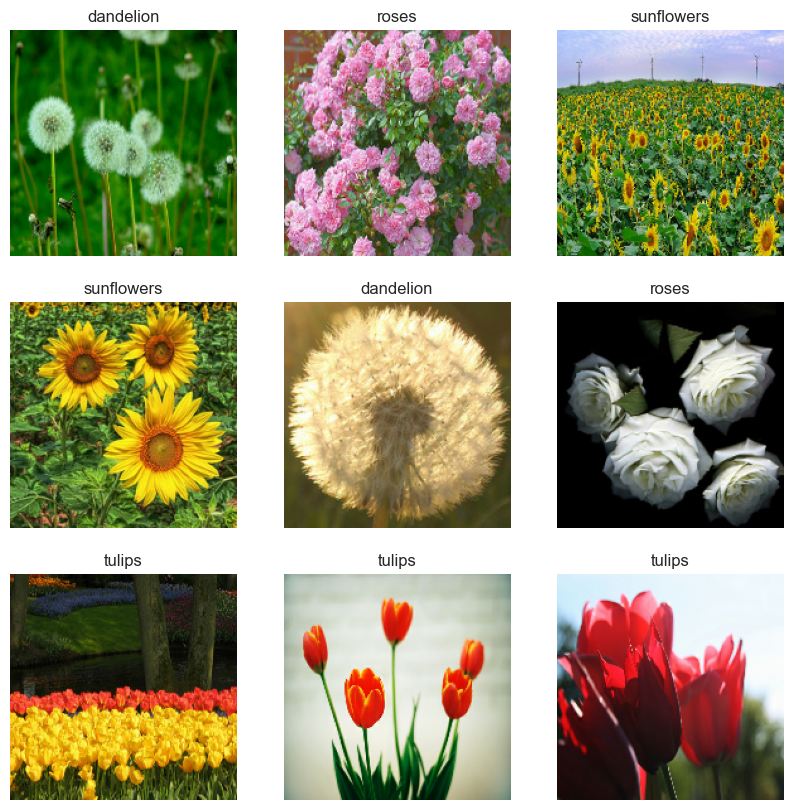

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

# .cache keeps images in memory after loaded off disk during the first epoch. if dataset is too large, it creates a performant on- disk cache.
# .prefetch overlaps data preprocessing and model execution while training
train_ds1 = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
print(train_ds1)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# standardize data to 0-1, RGB from 1-255 
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds1.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
0.0 0.99931014


In [9]:
num_classes = len(class_names)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

/Users/ashleycui/miniconda3/envs/tf2/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(train_ds1, epochs=10, validation_data=val_ds)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - accuracy: 0.3945 - loss: 1.4160 - val_accuracy: 0.5150 - val_loss: 1.2002
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 0.5600 - loss: 1.0721 - val_accuracy: 0.5790 - val_loss: 1.0169
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.6547 - loss: 0.9346 - val_accuracy: 0.5995 - val_loss: 1.0124
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 0.6542 - loss: 0.8869 - val_accuracy: 0.6580 - val_loss: 0.8853
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 0.6702 - loss: 0.8074 - val_accuracy: 0.6635 - val_loss: 0.8305
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 0.6983 - loss: 0.7784 - val_accuracy: 0.6989 - val_loss: 0.7737
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 0.7132 - loss: 0.7389 - val_accuracy: 0.7044 - val_loss: 0.7529
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 0.7409 - loss: 0.6839 - val_accu

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


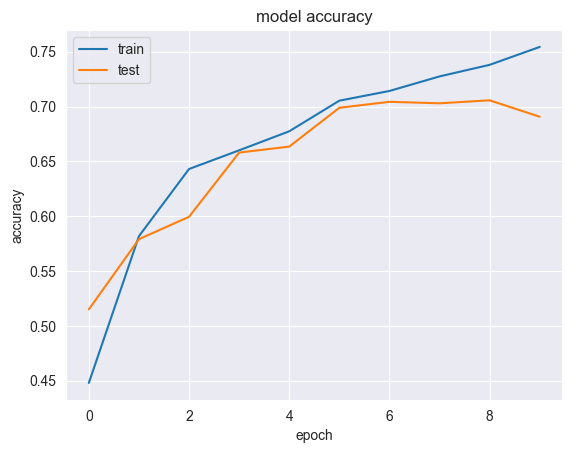

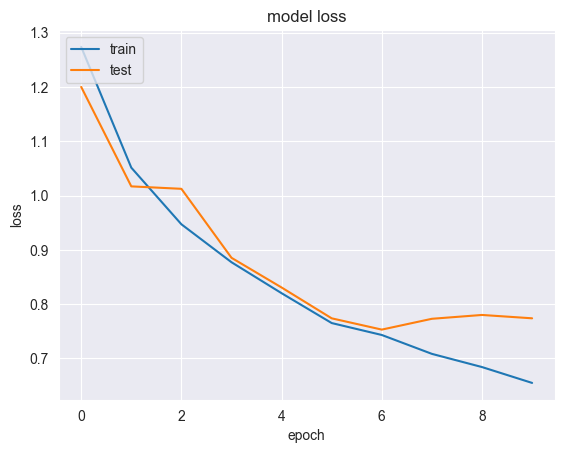

In [11]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [12]:
predictions = model.predict(img)
# print(predictions)

# score = [tf.nn.softmax(predictions[i], axis=1) for i in range(len(predictions))]
score = tf.nn.softmax(predictions)

print(score)

idx = np.argmax(score, axis=1)
print(sum(score[1]))

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[idx[1]], 100 * np.max(score[1]))
)

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
tf.Tensor(
[[4.6819816e-05 1.5252270e-03 2.3522396e-03 9.4848710e-01 4.7588587e-02]
 [3.9997209e-02 7.5789995e-02 7.7934846e-02 4.7856838e-01 3.2770956e-01]
 [3.2979887e-02 2.3638799e-03 1.8488705e-01 1.3492933e-02 7.6627630e-01]
 ...
 [8.0454327e-02 3.0531252e-02 2.0800747e-03 8.8098389e-01 5.9504248e-03]
 [3.1696691e-03 6.0847688e-05 6.0178900e-01 1.0774459e-03 3.9390302e-01]
 [7.4585492e-04 2.3346655e-03 8.9572698e-01 2.0202860e-02 8.0989473e-02]], shape=(2936, 5), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
This image most likely belongs to sunflowers with a 47.86 percent confidence.


In [13]:
# for one specific image that was not in training or validation sets
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img1 = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
print(img1)

img_array = tf.keras.utils.img_to_array(img1)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions1 = model.predict(img_array)
score1 = tf.nn.softmax(predictions1[0])
print(predictions1)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score1)], 100 * np.max(score1))
)

<PIL.Image.Image image mode=RGB size=180x180 at 0x315EDFD10>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[[-4.0966225 -3.5985575  1.0468214  1.9474651  2.1121383]]
This image most likely belongs to tulips with a 45.49 percent confidence.


tf.Tensor([4.6819816e-05 1.5252270e-03 2.3522396e-03 9.4848710e-01 4.7588587e-02], shape=(5,), dtype=float32)


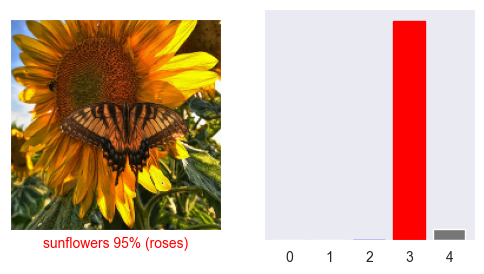

In [21]:
def plot_image(j, predictions_array, true_label, img):
    true_label, img = true_label[j], img[j] / 255.0
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    score1 = tf.nn.softmax(predictions_array)
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(score1),
                                         class_names[true_label]),
               color=color)

def plot_value_array(k, predictions_array, true_label):
    true_label = true_label[k]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    score1 = tf.nn.softmax(predictions_array)
    thisplot = plt.bar(range(5), score1, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(score1)
    print(score1)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], true_label, img)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i], true_label)
plt.show()